In [1]:
from djccx.frd.readfrd import readfrd



In [2]:
ifrd = readfrd("output/main.frd")

In [3]:
from matplotlib import pyplot as plt

In [4]:
data = ifrd["data"]

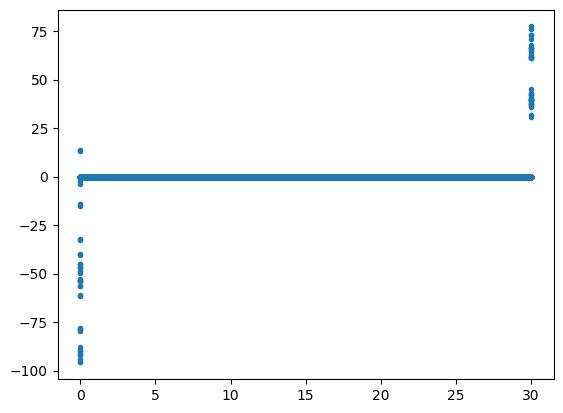

In [5]:
plt.plot(data["x"], data["F3"],".")

In [6]:
F3 = data["F3"][data["x"]< data["x"].mean()]
P = -2*F3.sum()
B = 25
L = 60
tn  = 2.934
tl = 0.475
t = tn + 4*tl
U = 5

In [7]:

Eflex = (P*L**3)/(4*U*B*t**3) * 1e-3

In [8]:
print("Eflex = ", Eflex)

Eflex =  14.059340757460456


In [9]:
import numpy as np
# cilindro
Ly = 25
Lx = 60
tn  = 2.934
tl = 0.475
r  = 3*tl/8
d_Y  = 0.74297
d_X  = 0.55872
d_SX = 0.5895
d_SY = 0.78042

A = np.pi*r**2



R = 10/6
nx_fibres = 3

lx = 10

z0 = tn/2
dx = 0.1 
dz = 0.1


hx = R
hz = tl

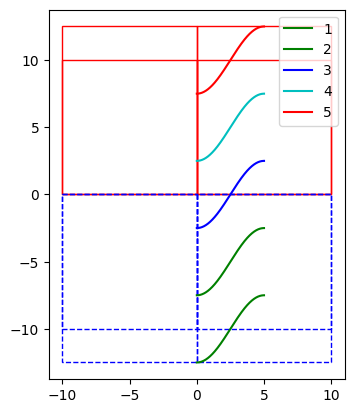

In [10]:
from matplotlib import pyplot as plt
import numpy as np


def rectangle(x, y, width, height, color,linestyle="-"):
    plt.fill([x, x, x + width, x + width], 
             [y, y + height, y + height, y], color="None", edgecolor=color, linestyle=linestyle)

lx = 10

rectangle(0,   0,  lx,  10  , 'red')
rectangle(0,   0, -lx,  10  , 'red')
rectangle(0,   0,  lx, 12.5 , 'red')
rectangle(0,   0, -lx, 12.5 , 'red')


rectangle(0,   0,  lx,  -10  , 'blue',linestyle="--")
rectangle(0,   0, -lx,  -10  , 'blue',linestyle="--")
rectangle(0,   0,  lx, -12.5 , 'blue',linestyle="--")
rectangle(0,   0, -lx, -12.5 , 'blue',linestyle="--")
# aspect ratio

R = 10/4
T = 10

t1 = np.linspace(0, 0.5, 500)

# =============================================================================
def fparams(t,y0):
    y = 4*R*t 
    x = -R*np.cos(2*np.pi*y/T) + y0
    return y,x

x1,y1 = fparams(t1,-4*R)
plt.plot(x1,y1, 'g',label="1")  

x2,y2 = fparams(t1,-2*R)
plt.plot(x2,y2, 'g',label="2")  

x3,y3 = fparams(t1,0)
plt.plot(x3,y3, 'b',label="3")

x4,y4 = fparams(t1,2*R)
plt.plot(x4,y4, 'c',label="4")

x5 = 4*R*t1 
y5 = -R*np.cos(2*np.pi*x5/T) + 4*R
plt.plot(x5,y5, 'r',label="5")

# =============================================================================


plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

In [11]:
z = - z0 - 5*hz/2
zspan = np.zeros_like(x3) + z
trajs_mid = [ 
            [x1,y1,zspan],
            [x2,y2,zspan],
            [x3,y3,zspan],
            [x4,y4,zspan],
            [x5,y5,zspan] ]

trajs_SY = [ np.array(traj).T for traj in trajs_mid]

In [12]:
yspan = np.arange(-Ly/2, Ly/2, hx)
yspan = yspan + hx/2

xspan = hx/2 + hx*np.arange(0, nx_fibres, 1)

trajs_Y = []
for iy in yspan:
    
    # x in [ 0, nx_fibres*hx]
    xspan_loop = np.linspace(0, nx_fibres*hx, 50)
    yspan_loop = np.zeros_like(xspan_loop) + iy
    zspan_loop = np.zeros_like(xspan_loop) - z0 - hz/2
    itraj = np.array([xspan_loop, yspan_loop, zspan_loop]).T
    trajs_Y.append(itraj)

trajs_X = []

for ix in xspan:
    # x in [ 0, nx_fibres*hx]
    yspan_loop = np.linspace(-Ly/2,Ly/2, 50)
    xspan_loop = np.zeros_like(yspan_loop) + ix

    zspan_loop = np.zeros_like(xspan_loop) - z0 - hz/2
    itraj = np.array([xspan_loop, yspan_loop, zspan_loop]).T
    trajs_X.append(itraj)

C:\Users\djoroya\AppData\Local\Temp\ipykernel_4600\3650008300.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(itraj[1:,0],


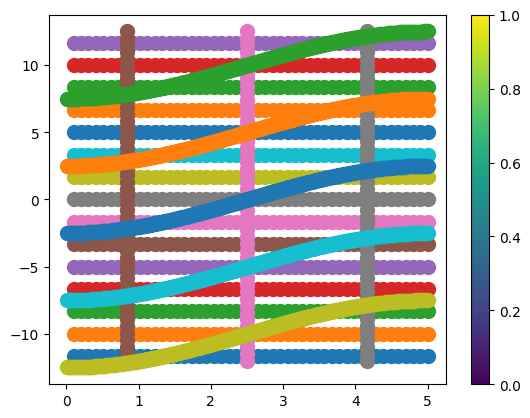

In [13]:
for itraj in [*trajs_Y, *trajs_X, *trajs_SY]:
    plt.scatter(itraj[1:,0],
                itraj[1:,1], s=100, cmap='viridis',vmax=1000,vmin=0)
    
plt.colorbar()

In [14]:
from scipy.interpolate import NearestNDInterpolator
from gmshtools.grid_section import grid_section


def compute_P1_max(data,idesign,d):

    x = data["x"]
    y = data["y"]
    z = data["z"]
    P1 = data["P1"]

    fcn = NearestNDInterpolator((x,y,z),P1)


    P1_mu_list = []
    P1_all = []
    for jj,jtrajs in enumerate(idesign):

        jtraj_diff = np.diff(jtrajs,axis=0)
        P1_mu_list_by = []
        for j in range(0,len(jtraj_diff),1):

            vec_z =  jtraj_diff[j]
            vec_z = vec_z/np.linalg.norm(vec_z)
            vec_x = np.cross(vec_z, [0,0,1])
            vec_x = vec_x/np.linalg.norm(vec_x)

            X,Y,Z = grid_section(jtrajs[j][0],
                                jtrajs[j][1],
                                jtrajs[j][2],
                                vec_z,
                                vec_x,
                                1.1*d,
                                1.1*r,
                                rho=150)
            P1 = fcn(X,Y,Z)
            P1_mu = np.mean(P1)
            P1_mu_list_by.append(P1_mu)
            P1_mu_list.append(P1_mu)

        # ============================
        P1_all.append(np.array(P1_mu_list_by))
        # ============================
    P1_max = np.max(P1_mu_list)
    P1_all = np.array(P1_all)
    return P1_max,P1_all

In [15]:
P1_max_Y,P1_all_Y = compute_P1_max(ifrd["data_blocks"][0],trajs_Y, d_Y)
P1_max_X,P1_all_X = compute_P1_max(ifrd["data_blocks"][0],trajs_X, d_X)
P1_max_SY,P1_all_SY = compute_P1_max(ifrd["data_blocks"][0],trajs_SY, d_SY)


C:\Users\djoroya\AppData\Local\Temp\ipykernel_4600\3570880827.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(data_cp["y"],data_cp["z"], s=0.1, cmap='viridis',vmax=1000,vmin=0)


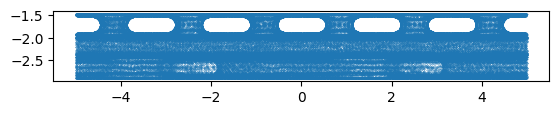

In [16]:
from djccx.inp.inp import inp
from djccx.frd.readfrd import readfrd
import numpy as np
from matplotlib import pyplot as plt
inp_f = inp("output/main.inp")
ifrd = readfrd("output/main.frd")
RESINA = inp_f.select("RESINA","elset")
df = RESINA.GetUniqueNodes(inp_f)
indx_frd = df.index.values

nodes_matrix = ifrd["data_blocks"][0].loc[indx_frd]
data_cp = nodes_matrix.copy()
data_cp = data_cp[(data_cp["x"] > -2.5) & (data_cp["x"] < 2.5)]
# y in -5, 5
data_cp = data_cp[(data_cp["y"] > -5) & (data_cp["y"] < 5)]
id_max = np.argmax(data_cp["P1"])

P1_max = data_cp["P1"].iloc[id_max]
x_max = data_cp["x"].iloc[id_max]
y_max = data_cp["y"].iloc[id_max]
z_max = data_cp["z"].iloc[id_max]

dist = np.sqrt((x_max - nodes_matrix["x"])**2 + \
                (y_max - nodes_matrix["y"])**2 + \
                (z_max - nodes_matrix["z"])**2)
        
nodes_matrix = nodes_matrix[dist < 0.05]
P1_max_resina = np.mean(nodes_matrix["P1"])
# plot xz view scatter 
plt.scatter(data_cp["y"],data_cp["z"], s=0.1, cmap='viridis',vmax=1000,vmin=0)
# ratio  1:1
plt.gca().set_aspect('equal', adjustable='box')

In [17]:
from loadsavejson.savejson import savejson
savejson({
    "Eflex": Eflex,
    "P1_max" : np.max([P1_max_Y,P1_max_X,P1_max_SY]),
    "P1_max_resina": P1_max_resina,
    "position":[x_max,y_max,z_max],
},"P1.json")